In [1]:
%matplotlib inline
!pip install tensorboardcolab

import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorboardcolab

Using TensorFlow backend.


In [2]:
# load cifar10 dataset 
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
# reshape (None, 1) -> (None)
y_train, y_test = [np.reshape(y_train, [-1]), np.reshape(y_test, [-1])]

# normalization 
x_train, x_test = [(x_train - x_train.max()) / (x_train.max() - x_train.min()),
                   (x_test - x_test.max()) / (x_test.max() - x_test.min())]

# N class
n_classes = 10
print('image shape : {}, label shape : {} '.format(x_train.shape, y_train.shape))
print('image shape : {}, label shape : {} '.format(x_test.shape, y_test.shape))
print('train minimun : {}, train_maximum : {} '.format(x_train.min(), x_train.max()))
print('tests minimun : {}, test_maximum : {} '.format(x_test.min(), x_test.max()))

image shape : (50000, 32, 32, 3), label shape : (50000,) 
image shape : (10000, 32, 32, 3), label shape : (10000,) 
train minimun : 0.0, train_maximum : 1.0 
tests minimun : 0.0, test_maximum : 1.0 


In [4]:
temp = x_train
ratio = int(len(x_train) * 0.7)
ratio_end = int(len(x_train) * 1.0)  ### TODO

x_train = temp[0:ratio, :, :, :]
x_validation = temp[ratio:ratio_end , :, :, :]

y_train_label = y_train[0:ratio]
y_validation_label = y_train[ratio:ratio_end ]

print(y_train_label[:10]) # label이 one_hot encoding상태가 아니다.

print(x_train.shape, y_train_label.shape)
print(x_validation.shape, y_validation_label.shape)

[6 9 9 4 1 1 2 7 8 3]
(35000, 32, 32, 3) (35000,)
(15000, 32, 32, 3) (15000,)


## Data Provider

In [0]:
class DataProvider(object):
    def __init__(self, x, y):
        self.epoch_count = 0
        
        self.data = x
        self.label = y
        
        npr.seed(42)
        
        self.indices = self.generate_indices()
        
    def generate_indices(self):
        indices = list(range(len(self.data)))
        npr.shuffle(indices)
        
        return indices
    
    def next_batch(self, batch_size):
        idx = batch_size
        if len(self.indices) < batch_size:
            print("all data consumed, epoch + 1")
            self.epoch_count += 1
            self.indices = self.generate_indices()
    
        target_indices = self.indices[:batch_size]
        del self.indices[:batch_size]
        
        return self.data[target_indices] , self.label[target_indices]

In [0]:
def cifar_generator(data, labels, batch_size=32):
    start_idx = 0
    num_step = len(data) // batch_size
    indexes = np.arange(0, len(data))
    while True:
        if start_idx >= num_step-1:
            np.random.shuffle(indexes)
            start_idx = 0
        else:
            start_idx += 1            
        batch_index = indexes[start_idx*batch_size:
                              (start_idx+1)*batch_size]

        batch_data = data[batch_index]
        batch_label = labels[batch_index]

        yield batch_data, batch_label

## Model B : Build  --> Model A와 동일한 Structure이고, Optimizer만 Momentum으로 변경함

In [7]:
graph = tf.Graph()
with graph.as_default() :
    xs = tf.placeholder(tf.float32, (None, 32, 32, 3), name='xs') # 32*32 = 1024
    ys = tf.placeholder(tf.int32, (None), name='ys')
    lr = tf.placeholder_with_default(0.001, (), name='lr')
    wd = tf.placeholder_with_default(0.9, (), name='wd')
    is_train = tf.placeholder_with_default(False, (), name='is_train')
    m = tf.placeholder_with_default(0.9, (), name='momentum')
    
    with tf.name_scope('conv1') :   ## filters is number of channels
        kernel_init   = tf.zeros([3, 3, 3, 32]) 
        bias_init     = tf.zeros([32])
        conv1_kernel1 = tf.Variable(kernel_init, name='kernel1')               
        conv1_bias1   = tf.Variable(bias_init, name='bias1')
        
        layer         = tf.nn.conv2d(xs, conv1_kernel1, strides=[1,1,1,1], padding='SAME')
        layer         = layer + conv1_bias1
        layer         = tf.nn.relu(layer)
        
        kernel_init   = tf.zeros([3, 3, 32, 32]) 
        bias_init     = tf.zeros([32])
        conv1_kernel2 = tf.Variable(kernel_init, name='kernel2')     
        conv1_bias2   = tf.Variable(bias_init, name='bias2')
        
        layer         = tf.nn.conv2d(layer, conv1_kernel2, strides=[1,1,1,1], padding='SAME') 
        layer         = layer + conv1_bias2
        layer         = tf.nn.relu(layer)
          
            
    with tf.name_scope('conv2') :  
        kernel_init   = tf.zeros([3, 3, 32, 64]) 
        bias_init     = tf.zeros([64])
        conv2_kernel1 = tf.Variable(kernel_init, name='kernel1')    
        conv2_bias1   = tf.Variable(bias_init, name='bias1')    
        
        layer         = tf.nn.conv2d(layer, conv2_kernel1, strides=[1,1,1,1], padding='SAME') 
        layer         = layer + conv2_bias1
        layer         = tf.nn.relu(layer)
    
        kernel_init   = tf.zeros([3, 3, 64, 64]) 
        bias_init     = tf.zeros([64])
        conv2_kernel2 = tf.Variable(kernel_init, name='kernel2')   
        conv2_bias2   = tf.Variable(bias_init, name='bias2')    
        
        layer         = tf.nn.conv2d(layer, conv2_kernel2, strides=[1,1,1,1], padding='SAME')    
        layer         = layer + conv2_bias2
        layer         = tf.nn.relu(layer)
    
        pool          = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)        

    with tf.name_scope('conv3') :       
        kernel_init   = tf.zeros([3, 3, 64, 128]) 
        bias_init     = tf.zeros([128])
        conv3_kernel2 = tf.Variable(kernel_init, name='kernel2')           
        conv3_bias2   = tf.Variable(bias_init, name='bias2')    
        
        layer         = tf.nn.conv2d(pool, conv3_kernel2, strides=[1,3,3,1], padding='SAME') 
        layer         = layer + conv3_bias2
        layer         = tf.nn.relu(layer)
    
        pool          = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)      

    with tf.name_scope('Reconstruct') : 
        flatten       = tf.layers.flatten(pool)
        in_           = flatten.shape[1] 
        
        fc1_weights1  = tf.Variable(tf.zeros(shape = [in_, 1024], dtype = tf.float32), name = "fc1_weights1")
        fc1_bias1     = tf.Variable(tf.zeros(shape = [1024], dtype = tf.float32), name = "fc1_bias1")
        fc1_logits    = tf.matmul(flatten, fc1_weights1) + fc1_bias1
        fc1_act       = tf.nn.relu(fc1_logits)
        fc1_dropout   = tf.layers.Dropout(0.5)(fc1_act, training = is_train)
        fc1_result    = tf.identity(fc1_dropout, "fc1_result")
        
        fc2_weights1  = tf.Variable(tf.zeros(shape = [1024, 1024], dtype = tf.float32), name = "fc2_weights1")
        fc2_bias1     = tf.Variable(tf.zeros(shape = [1024], dtype = tf.float32), name = "fc2_bias1")
        fc2_logits    = tf.matmul(fc1_result, fc2_weights1) + fc2_bias1
        fc2_act       = tf.nn.relu(fc2_logits)
        fc2_dropout   = tf.layers.Dropout(0.5)(fc2_act, training = is_train)
        fc2_result    = tf.identity(fc2_dropout, "fc2_result")
        
        y_pred        = tf.layers.Dense(10, activation=None, name='y_pred')(fc2_result) 
    # Layer #	Kernel Stride	Dilation	Padding	Input Size	Output Size	Receptive Field
    #    1	      3	       1	   1	       2	      32    	 32	          3
    #    2	      3	       1	   1	       2	      32    	 32	          5
    #    3	      3	       1	   1	       2	      32    	 32	          7
    #    4	      3	       1	   1	       2	      32    	 32	          9
    #    5	      2	       2	   1	       0	      32    	 16	          10
    #    6	      3	       3	   1	       1	      16    	 6	          14
    #    7	      2	       2	   1	       0	      6	         3 	          20       
    
    with tf.name_scope('Loss') :
        sce_loss      = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=ys, logits=y_pred))
        l2_loss       = tf.add_n([tf.nn.l2_loss(var) for var in tf.global_variables()])
        loss          = sce_loss + wd * l2_loss
    loss = tf.identity(loss, name='loss')
        
    with tf.name_scope('metric') :
        rmse = tf.sqrt(loss)
    
    with tf.name_scope('accuracy') :
        pred        = tf.cast(tf.arg_max(y_pred, 1), tf.int32)
        correct     = tf.equal(pred, ys)
        accuracy    = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        # add tensor to tensorboard
        acc_tb      = tf.summary.scalar(name='accuracy', tensor=accuracy)

    with tf.name_scope('train') :
        global_step = tf.train.get_or_create_global_step()
        #train_op   = tf.train.AdamOptimizer(lr).minimize(loss, global_step = global_step)
        
        optimizer   = tf.train.MomentumOptimizer(lr, momentum = m, use_nesterov = False)
        train_op    = optimizer.minimize(loss, global_step = global_step)
        

W0618 02:04:50.449737 140573816301440 deprecation.py:323] From <ipython-input-7-3e1aa8e8830e>:64: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0618 02:04:50.761130 140573816301440 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0618 02:04:51.226019 140573816301440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the

## Model B : Train

### Load trained weight and bias

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir ./model
!cp gdrive/My\ Drive/vgg/* model/ # from, to 임

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
from tensorflow.python.training import checkpoint_utils as cp

# 변수 불러오기
var_names = cp.list_variables('./model/vgg_net_model_a')   
print(var_names)


[('Reconstruct/fc1_bias1', [1024]), ('Reconstruct/fc1_bias1/Adam', [1024]), ('Reconstruct/fc1_bias1/Adam_1', [1024]), ('Reconstruct/fc1_weights1', [1152, 1024]), ('Reconstruct/fc1_weights1/Adam', [1152, 1024]), ('Reconstruct/fc1_weights1/Adam_1', [1152, 1024]), ('Reconstruct/fc2_bias1', [1024]), ('Reconstruct/fc2_bias1/Adam', [1024]), ('Reconstruct/fc2_bias1/Adam_1', [1024]), ('Reconstruct/fc2_weights1', [1024, 1024]), ('Reconstruct/fc2_weights1/Adam', [1024, 1024]), ('Reconstruct/fc2_weights1/Adam_1', [1024, 1024]), ('conv1/bias1', [32]), ('conv1/bias1/Adam', [32]), ('conv1/bias1/Adam_1', [32]), ('conv1/bias2', [32]), ('conv1/bias2/Adam', [32]), ('conv1/bias2/Adam_1', [32]), ('conv1/kernel1', [3, 3, 3, 32]), ('conv1/kernel1/Adam', [3, 3, 3, 32]), ('conv1/kernel1/Adam_1', [3, 3, 3, 32]), ('conv1/kernel2', [3, 3, 32, 32]), ('conv1/kernel2/Adam', [3, 3, 32, 32]), ('conv1/kernel2/Adam_1', [3, 3, 32, 32]), ('conv2/bias1', [64]), ('conv2/bias1/Adam', [64]), ('conv2/bias1/Adam_1', [64]), ('c

In [0]:
# 값 불러오기
conv1_w1  = cp.load_variable('./model/vgg_net_model_a', 'conv1/kernel1')   
conv1_b1  = cp.load_variable('./model/vgg_net_model_a', 'conv1/bias1')
conv1_w2  = cp.load_variable('./model/vgg_net_model_a', 'conv1/kernel2')   
conv1_b2  = cp.load_variable('./model/vgg_net_model_a', 'conv1/bias2')

conv2_w1  = cp.load_variable('./model/vgg_net_model_a', 'conv2/kernel1')   
conv2_b1  = cp.load_variable('./model/vgg_net_model_a', 'conv2/bias1')
conv2_w2  = cp.load_variable('./model/vgg_net_model_a', 'conv2/kernel2')   
conv2_b2  = cp.load_variable('./model/vgg_net_model_a', 'conv2/bias2')

conv3_w2  = cp.load_variable('./model/vgg_net_model_a', 'conv3/kernel2')    # 오타.. TODO
conv3_b2  = cp.load_variable('./model/vgg_net_model_a', 'conv3/bias2')

f1_w1    = cp.load_variable('./model/vgg_net_model_a', 'Reconstruct/fc1_weights1')   
f1_b1    = cp.load_variable('./model/vgg_net_model_a', 'Reconstruct/fc1_bias1')
f2_w1    = cp.load_variable('./model/vgg_net_model_a', 'Reconstruct/fc2_weights1')   
f2_b1    = cp.load_variable('./model/vgg_net_model_a', 'Reconstruct/fc2_bias1')

In [12]:
print(graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

[<tf.Variable 'conv1/kernel1:0' shape=(3, 3, 3, 32) dtype=float32_ref>, <tf.Variable 'conv1/bias1:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv1/kernel2:0' shape=(3, 3, 32, 32) dtype=float32_ref>, <tf.Variable 'conv1/bias2:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv2/kernel1:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'conv2/bias1:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv2/kernel2:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'conv2/bias2:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv3/kernel2:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'conv3/bias2:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Reconstruct/fc1_weights1:0' shape=(1152, 1024) dtype=float32_ref>, <tf.Variable 'Reconstruct/fc1_bias1:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'Reconstruct/fc2_weights1:0' shape=(1024, 1024) dtype=float32_ref>, <tf.Variable 'Reconstruct/fc2_bias1:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'y_pred/kern

## Model B : Train

In [13]:
with graph.as_default() :
    
    log_dir = "./log/vgg_net_model_b"   
    lode_dir = "./model/vgg_net_model_a"
    save_dir = "./model/vgg_net_model_b"    # dir + file name.
    
    # 텐서보드에 연결합니다.
    # tbc = tensorboardcolab.TensorBoardColab(graph_path = log_dir)
    train_writer = tf.summary.FileWriter(logdir = log_dir)
    train_writer.add_graph(tf.get_default_graph())
    merged_all = tf.summary.merge_all()    
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer()) 
    
    # Saver를 이용하지 않고 pretrain된 data를 불러와서 사용해보자.
    # Step2 : 기록
    # saver = tf.train.Saver(var_list = transfer_weights)

    # loading parameters
    # saver.restore(sess, save_path = lode_dir)


    # Training
    batch_size = 1000
    n_epoch = 0 # 30
    n_step = int(len(x_train) // batch_size)  # //은 몫이다.
    learing_rate = 0.001
    weight_decay = 0.0005
    
    # instance 생성
    train_generator = cifar_generator(x_train, y_train_label, batch_size)
    
    train_loss = []
    valid_loss = []
    valid_acc = []
    cnt = 0
    minimum_loss = 1.1
    momentum = 0.9

    
    # pre training된 weight, bais 넣기 ## Numpy array로 직접 넣기
    feed_dict = { xs : x_validation, ys : y_validation_label, 
                 wd : 0, m : 0, is_train : False, 
                 conv1_kernel1 : conv1_w1, conv1_bias1 : conv1_b1, 
                 conv1_kernel2 : conv1_w2, conv1_bias2 : conv1_b2, 
                 conv2_kernel1 : conv2_w1, conv2_bias1 : conv2_b1, 
                 conv2_kernel2 : conv2_w2, conv2_bias2 : conv2_b2, 
                 conv3_kernel2 : conv3_w2, conv3_bias2 : conv3_b2,
                 fc1_weights1  : f1_w1,    fc1_bias1 : f1_b1,
                 fc2_weights1  : f2_w1,    fc2_bias1 : f2_b1}
    loss_, acc_, fc2_weights1_= sess.run([rmse, accuracy, fc2_weights1], feed_dict = feed_dict)
    print("Loading결과 확인 -> loss = {:.4f}, acc = {:.2f}%".format(loss_, acc_*100))
    print("weight를 제대로 가져오는지 확인 -> ", fc2_weights1_)


        
    # for i in tqdm(range(n_epoch)) :
    #     for step in range(n_step) :
    #         batch_xs, batch_ys = next(train_generator)
    #         _, train_loss_, tbs_train_ = sess.run([train_op, rmse, merged_all], feed_dict = { xs: batch_xs, 
    #                                                                                           ys: batch_ys, 
    #                                                                                           lr: learing_rate,
    #                                                                                           wd : weight_decay,
    #                                                                                           m : momentum,
    #                                                                                           is_train : True})
    #         train_writer.add_summary(tbs_train_, global_step=cnt) # 흠 되야 하는데 안된다.
    #         cnt += 1
    #         train_loss.append(train_loss_)
    #         
    #         # check validation set
    #         if step % 100 == 0 :
    #             loss_, acc_ = sess.run([rmse, accuracy], feed_dict = { xs: x_validation, 
    #                                                                    ys: y_validation_label,
    #                                                                    wd : weight_decay,
    #                                                                    m : momentum,
    #                                                                    is_train : False})
    #             valid_loss.append(loss_)
    #             valid_acc.append(acc_)
    #             
    #             # Save the model
    #             if loss_ < minimum_loss :
    #                 print("log current model!")
    #                 minimum_loss = loss_
    #                 saver.save(sess, save_path = save_dir)
    #     print("loss = {:.4f}, acc = {:.2f}%".format(loss_, acc_*100))
    # print("loss = {:.4f}, acc = {:.2f}%".format(loss_, acc_*100))
    
    train_writer.flush() # file을 disk에 쓴다

Loading결과 확인 -> loss = 1.5269, acc = 16.36%
weight를 제대로 가져오는지 확인 ->  [[ 2.71307137e-02 -1.25479437e-02  2.35868134e-02 ...  3.18341865e-03
  -1.23903230e-02 -3.40513252e-02]
 [ 1.76205412e-02  8.06861464e-03 -1.41466055e-02 ...  2.62078624e-02
  -1.16349792e-03 -1.31203244e-02]
 [ 1.31812096e-02  1.92907900e-02 -8.44401121e-03 ... -4.72040083e-05
   3.89633328e-02  4.45121853e-03]
 ...
 [ 1.60037894e-02 -1.04974322e-02  1.55837657e-02 ...  2.07463447e-02
   2.84298230e-03  2.46870182e-02]
 [ 9.52524599e-04 -3.47122294e-03  3.87140177e-02 ...  1.65685099e-02
  -2.02795472e-02 -1.26976082e-02]
 [ 3.02585840e-06  1.30706057e-05  7.41337362e-06 ... -5.87957256e-05
   1.98324210e-06  5.80111646e-06]]


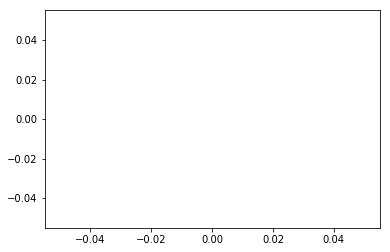

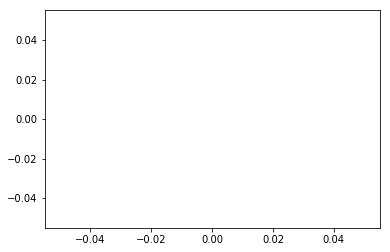

In [14]:
plt.plot(np.arange(0, len(train_loss), 1), train_loss)
plt.show()
plt.plot(np.arange(0, len(valid_loss), 1), valid_loss)
plt.show() # train과 validation 모두 봐야 한다.

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir gdrive/My\ Drive/vgg
!mv ./model/vgg* gdrive/My\ Drive/vgg
!mv ./model/checkpoint gdrive/My\ Drive/vgg

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘gdrive/My Drive/vgg’: File exists


In [0]:
# with graph.as_default() :
#     
#     sess = tf.Session()
#     sess.run([tf.global_variables_initializer(),
#               tf.local_variables_initializer()])    
#     print(graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))
#     
#     lode_dir = "./model/vgg_net_model_a"
#     
#     # meta graph  eval
#     saver = tf.train.import_meta_graph('./model/vgg_net_model_a.meta')
#     #saver.restore(sess, tf.train.latest_checkpoint('./'))
#     saver.restore(sess, save_path = lode_dir)
#         
#     layer1_w = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "convolution_layer_1/kernel:0")
#     layer1_b = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "convolution_layer_1/bias:0")
#     
#     layer2_w = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "convolution_layer_2/kernel:0")
#     layer2_b = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "convolution_layer_2/bias:0")
#     
#     layer3_w = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "convolution_layer_3/kernel:0")
#     layer3_b = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "convolution_layer_3/bias:0")
#     
#     layer3_w2 = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "convolution_layer_3/kernel_1:0")
#     layer3_b2 = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "convolution_layer_3/bias_1:0")
#     
#     fc1_w = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "FC1/kernel:0")
#     fc1_b = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "FC1/bias:0")
#     
#     fc2_w = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "FC2/kernel:0")
#     fc2_b = graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "FC2/bias:0")
#     
#     transfer_weights = layer1_w + layer1_b + \
#                        layer2_w + layer2_b + \
#                        layer3_w + layer3_b + layer3_w2 + layer3_b2 + \
#                        fc1_w + fc1_b + fc2_w + fc2_b
#     
#     # transfer_weights = layer1_w
#     print(transfer_weights)